In [2]:
#step1 import all the required libraries
#install this version of transformers and pytorch
!pip install transformers==2.8.0
!pip install torch==1.4.0
from transformers import T5Tokenizer, T5ForConditionalGeneration
import tensorflow_datasets as tfds
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import nltk,spacy,re,string,random,time
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from collections import Counter 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from attension import AttentionLayer
from keras.initializers import Constant
from keras.optimizers import Adam
from keras import backend as K 
from rouge import rouge_n,rouge_l_sentence_level,rouge 
from bleau import compute_bleu
#ignore warnings
import warnings
warnings.filterwarnings("ignore")
#stopwords removal list
nltk.download('stopwords')
#punkt for tokenization
nltk.download('punkt')
#for tokenaizations
nltk.download('wordnet')
#combine all the stopwords and create one single list of stopwords
s1=stopwords.words('english')
s2=list(STOP_WORDS)
s3=list(STOPWORDS)
#final list of stopwords
stop_words = s1+s2+s3
#use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#step2
#contraction are used to replace words with their longer meaningfull counter parts 
contraction = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"rec'd": "received"
}
#rec'd this is my addition to the list of contractions

#step3
#process_text function is used to remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings
def process_text(text,contractions,remove_stopwords = True):
  #convert words to lower case
  text = text.lower()
    
  #replace contractions with their longer forms 
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
    text = " ".join(new_text)
    
  #format words and remove unwanted characters
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) #remove https string
  text = re.sub(r'\<a href', ' ', text) #remove hyperlink
  text = re.sub(r'&amp;', '', text) #remove & in text
  text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text) #remove unwanted charecters like puntuation and others
  text = re.sub(r'<br />', ' ', text) #remove new line spaces
  text = re.sub(r'\'', ' ', text) #remove slashes
  text = " ".join(text.split()) #remove trailing spaces 
  #string.printable returns all sets of punctuation, digits, ascii_letters and whitespace.
  printable = set(string.printable)
  #filter to remove punctuations,digits, ascii_letters and whitespaces
  text = "".join(list(filter(lambda x: x in printable, text))) 
  #remove stop words is true then remove stopwords also
  if remove_stopwords:
    text = text.split()
    text = [w for w in text if not w in stop_words]
    text = " ".join(text)

  return text

#step4
#get_data function gets the data from gz file into a dataframe and process the columns
#stops are not removed for summary they are only removed from text this is done to get more human like summaries
#after processing it returns a dataframe
def get_data(contractions):
  st=time.time()
  #load the data into a dataframe
  df = pd.read_json('/content/drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry_5.json.gz', lines=True, compression='gzip')
  #drop unwanted columns
  df.drop(columns=['reviewerID', 'asin', 'reviewerName', 'helpful','overall','unixReviewTime', 'reviewTime'],inplace=True)
  print("length of the data",len(df))
  #apply preprocess function on the columns of the dataframe
  df['reviewText'] = df['reviewText'].apply(lambda x: process_text(x,contractions,remove_stopwords = True))
  df['summary'] = df[ 'summary'].apply(lambda x: process_text(x,contractions,remove_stopwords = False))
  #write preprocesssed data to csv file
  df.to_csv("/content/drive/MyDrive/product_reviews.csv",index=False)
  print("total time to generate data and write in csv file ",time.time()-st)


#step5
#get_embeddings function is used to gett te word embeddings 
#i am using conceptual number batch word embeddings
def get_embeddings():
  #get word embeddings
  embeddings_index = {}
  with open('/content/drive/MyDrive/numberbatch-en-19.08.txt', encoding='utf-8') as f:
    for line in f:
      values = line.split(' ')
      word = values[0]
      embedding = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = embedding

  print('Word embeddings:', len(embeddings_index))
  return embeddings_index

#step6
#this function is used to build vocabulary
def get_vocab(embeddings_index,word_counts,threshold):
  #get the number of missing words 
  missing_words={k:v for k,v in word_counts.items() if v >= threshold if k not in embeddings_index.keys()}
  missing_ratio = round(len(missing_words)/len(word_counts),4)*100
  print("Number of words missing from word_embeddings:", len(missing_words))
  print("Percent of words that are missing from our vocabulary: {}%".format(missing_ratio))

  #mapping vocab to index
  lr=iter([item for item in range(0,len(word_counts))])
  vocab_to_int={k:next(lr) for k,v in word_counts.items() if v >= threshold or k in embeddings_index.keys()}

  #mapping index to vocab 
  lr=iter([item for item in range(0,len(word_counts))])
  int_to_vocab={next(lr):k for k,v in word_counts.items() if v >= threshold or k in embeddings_index.keys()}

  # Special tokens that will be added to our vocab
  codes = ["<UNK>","<PAD>","<EOS>","<GO>"]

  # Add codes to vocab
  for code in codes:
      vocab_to_int[code] = len(vocab_to_int)
      int_to_vocab[len(int_to_vocab)] = code
  
  #print usage of words in our model and their percent
  usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100
  print("Total number of unique words:", len(word_counts))
  print("Number of words we will use:", len(vocab_to_int))
  print("Percent of words we will use: {}%".format(usage_ratio))
  print("length vocab_to_int",len(vocab_to_int))
  print("length int_to_vocab",len(int_to_vocab))

  return vocab_to_int,int_to_vocab

#step7
#function to map words with its word embeddings 
#if embeddings not found for the word then map it with a random number in range(-1.0,1.0)
def word_embedding_index(vocab_to_int,embeddings_index):
  #using 300 for embedding dimensions to match CN's vectors.
  embedding_dim = 300
  nb_words = len(vocab_to_int)
  
  # Create matrix with default values of zero
  word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
  for word, i in vocab_to_int.items():
    if word in embeddings_index:
      word_embedding_matrix[i] = embeddings_index[word]
    else:
      # If word not in CN, create a random embedding for it
      new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
      #embeddings_index[word] = new_embedding
      word_embedding_matrix[i] = new_embedding

  # Check if value matches len(vocab_to_int)
  print("length of word embedding matrix",len(word_embedding_matrix))
  return word_embedding_matrix

#step8
#append unk and eos tokens 
#if eos is equal to true then append go and eos token at begining and end of the summary
#add unknown token for word not found in vocabulary
def convert_to_ints(text,vocab_to_int,eos=False):
  ints = []
  for word in text.split():
    if word in vocab_to_int:
      ints.append(vocab_to_int[word])
    else:
      ints.append(vocab_to_int["<UNK>"])
  if eos:
    ints.insert(0,vocab_to_int["<GO>"])
    ints.insert(len(ints),vocab_to_int["<EOS>"])
  return ints

#step9
#count unknown tokens
def count_unk(text):
  unk=0
  eos=0
  #print(text)
  for value in text:
    if 41413 in value:
      unk+=1
  return unk

#step10
def counts(val):
  c=0
  for i in val:
    try:
      if i==41413:
        c+=1
    except:
      pass
  return c

#step11
#remove rows from data frame that dosent staisfy the condition this is done so model is trained with proper data
#redundancey is less and input text is accurate
def get_refined_output(df,max_rl,max_sl):
  unk_rl=1 #unknown token review limit
  unk_sl=0 #unknown token summary limit
  min_rl=2 #minimum review length
  #get the total length of reviewText this is used for sorting
  df["total_length"]=df['reviewText'].apply(lambda x: len(x))
  #get reviewText whose length is greater then minimum review length 
  df=df[df['reviewText'].apply(lambda x: len(x)>=min_rl)]
  #get reviewText whose length is less than maximum review length
  df=df[df['reviewText'].apply(lambda x: len(x)<=max_rl)]
  #filter out the unknwon tokens based on unknown token reviewText limit
  df=df[df['reviewText'].apply(lambda x: counts(x)<=unk_rl)]
  #get summary whose length is less than maximum summary length
  df=df[df['summary'].apply(lambda x: len(x)<=max_sl)]
  #filter out the unkown tokens based on unkown token summary limit
  df=df[df['summary'].apply(lambda x: counts(x)<=unk_sl)]  
  #sort the values in ascending order
  df.sort_values(by=["total_length"],ascending=True,inplace=True)
  #drop unwanted columns
  df.drop(columns=["total_length","word"],inplace=True)
  #reset index
  df.reset_index(drop=True,inplace=True)
  return df 

#step12
#function to plot the length of training, validation and testing
def plot_tr_tval_tt_len(xtr,xval,xtt):
  names = ['Training','Validation','Testing']
  values = [len(xtr),len(xval),len(xtt)]
  plt.figure(figsize=(10,5))
  plt.subplot(131)
  plt.bar(names,values,color=['darkorange','coral','coral'],edgecolor='darkblue')
  plt.suptitle('Categorical Plotting')
  plt.show()

#step13
#function to plot loss and accuracy curves on training and validation set
def plotgraph(history):
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'firebrick',linewidth=3.0)
  plt.plot(history.history['accuracy'],'turquoise',linewidth=3.0)
  plt.plot(history.history['val_loss'],'midnightblue',linewidth=3.0)
  plt.legend(['Training loss','Training Accuracy','Validation loss'],fontsize=18)
  plt.xlabel('Epochs',fontsize=16)
  plt.ylabel('Loss and Accuracy',fontsize=16)
  plt.title('Loss Curves and Accuracy Curves for text summarization',fontsize=16)

#step14
#this function is used to get the preprocessed csv file for our text summarizer
def Get_the_data():
  #lower the string in contractions and convert it into dict
  contractions = dict((k.lower(), v.lower()) for k, v in contraction.items())
  #till this step all data is processed and we get our csv file of cleaned texts
  get_data(contractions)

  #free memory
  del contractions

#step15 is used to call function Get_the_data which get the preprocessed data and writes it into a csv file
#Get_the_data()

#step16
#this function combines all the above ouput generated by the above function in a proper squence of steps 
def combining_all_steps():
  
  st=time.time()
  #get the final cleaned data
  df=pd.read_csv('/content/drive/MyDrive/product_reviews.csv')[:100000]
  print("The length of dataset is ",len(df))
  #combine reviewText and summary so common vocabulary can be created by finding frequent words 
  df["word"]=df[['reviewText','summary']].apply(lambda x : '{} {}'.format(x[0],x[1]), axis=1)
  #get frequency of words
  word_counts=pd.Series(np.concatenate([x.split() for x in df.word])).value_counts()
  word_counts=word_counts.to_dict()
  #print(type(word_counts))
  print("vocab length",len(word_counts))
  #set the threshold 
  threshold = 20
  max_rl=80 #maximum review length
  max_sl=10 #maximum summary length
  #get the embeddings matrix 
  embeddings_index= get_embeddings()
  #get vocab to index and index to vocab mapping of words
  vocab_to_int,int_to_vocab=get_vocab(embeddings_index,word_counts,threshold)
  #get word embedding for the words in vocab
  word_embedding_matrix=word_embedding_index(vocab_to_int,embeddings_index)
  #convert words to integers based on their index positions
  df['reviewText'] = df['reviewText'].apply(lambda x: convert_to_ints(str(x),vocab_to_int,eos=False))
  df['summary'] = df[ 'summary'].apply(lambda x: convert_to_ints(str(x),vocab_to_int,eos=True))
  print("after word to index for reviewText",df["reviewText"][0])
  print("after word to index for summary",df["summary"][0])
  rvunk=count_unk(df["reviewText"])
  smunk=count_unk(df["summary"])
  print("total number of unk token are",rvunk+smunk)
  #apply the filters and get the final preprocessed data
  df=get_refined_output(df,max_rl,max_sl)
  print("length of dataset that will be used",len(df))
  #split data into 75% train, 15% validation and 15% test datasets
  x_tr,x_val,y_tr,y_val=train_test_split(df['reviewText'],df['summary'],test_size=0.3,random_state=1,shuffle=True)
  x_tt,x_val,y_tt,y_val=train_test_split(x_val,y_val,test_size=0.5,random_state=1,shuffle=True)
  print("length of split datasets train {}, test {} and validation {}".format(len(x_tr),len(x_tt),len(x_val)))
  print("Vocabulary Size: {}".format(len(vocab_to_int)))
  print("voc_to_int_",vocab_to_int['<UNK>'],vocab_to_int['<PAD>'],vocab_to_int['<EOS>'])
  #reset index
  x_tr=x_tr.reset_index()
  y_tr=y_tr.reset_index()
  x_tt=x_tt.reset_index()
  y_tt=y_tt.reset_index()
  x_val=x_val.reset_index()
  y_val=y_val.reset_index()
  #find max lenght just to verfiy the output of get refined function
  #max([len(sentence) for sentence in y_tt["summary"]])
  #pad the reviewText and summary to the specified max length
  xtr=pad_sequences(x_tr["reviewText"], padding='post',maxlen=max_rl, value=vocab_to_int["<PAD>"])
  ytr=pad_sequences(y_tr["summary"], padding='post',maxlen=max_sl, value=vocab_to_int["<PAD>"])
  xtt=pad_sequences(x_tt["reviewText"], padding='post',maxlen=max_rl, value=vocab_to_int["<PAD>"])
  ytt=pad_sequences(y_tt["summary"], padding='post',maxlen=max_sl, value=vocab_to_int["<PAD>"])
  xval=pad_sequences(x_val["reviewText"], padding='post',maxlen=max_rl, value=vocab_to_int["<PAD>"])
  yval=pad_sequences(y_val["summary"], padding='post',maxlen=max_sl, value=vocab_to_int["<PAD>"])
  #find the number of unique tokens in the list
  #flat_list_rt = [item for sublist in df["reviewText"] for item in sublist]
  #flat_list_s = [item for sublist in df["summary"] for item in sublist]
  #rt=len(np.unique(flat_list_rt))
  #st=len(np.unique(flat_list_s))
  #print("number of unique tokens reviewText {} and summary {}".format(rt,st))
  #plot the length of training, validation and testing
  plot_tr_tval_tt_len(xtr,xval,xtt)
  print("total time to complete all the above steps and get final data ",time.time()-st)
  #free memory delete values stored in variables which are not required further
  del df,word_counts,embeddings_index,x_tr,x_val,y_tr,y_val,x_tt,y_tt

  return xtr,ytr,xtt,ytt,xval,yval,vocab_to_int,int_to_vocab,word_embedding_matrix,max_rl,max_sl  

#step17
#function to get summary given a sequence
def seq_to_summary(seq,vocab_to_int,int_to_vocab):
  newstring=''
  for i in seq:
    if ((i!=0 and i!=vocab_to_int['<GO>']) and i!=vocab_to_int['<EOS>']):
      newstring=newstring+int_to_vocab[i]+' '
  return newstring
  
#step18
#function to get text given a sequence
def seq_to_text(seq,int_to_vocab):
  newstring=''
  for i in seq:
    if (i!=0):
      newstring=newstring+int_to_vocab[i]+' '
  return newstring

#step19
#this function get the data for the pretrained model t5small
def combining_all_steps_t5():
  #get the final cleaned data
  df=pd.read_csv('/content/drive/MyDrive/product_reviews.csv')[:117799]
  print("The length of dataset is ",len(df))
  
  #set the threshold 
  threshold = 20
  max_rl=80 #maximum review length
  max_sl=10 #maximum summary length
  
  #get reviewText whose length is less than maximum review length
  df['reviewText']=df['reviewText'].str.slice(0,max_rl)
  
  #get summary whose length is less than maximum summary length
  df['summary']=df['summary'].str.slice(0,max_rl)

  #split data into 75% train, 15% validation and 15% test datasets
  x_tr,x_val,y_tr,y_val=train_test_split(df['reviewText'],df['summary'],test_size=0.3,random_state=1,shuffle=True)
  x_tt,x_val,y_tt,y_val=train_test_split(x_val,y_val,test_size=0.5,random_state=1,shuffle=True)

  #reset index
  x_tr=x_tr.reset_index()
  y_tr=y_tr.reset_index()
  x_tt=x_tt.reset_index()
  y_tt=y_tt.reset_index()
  x_val=x_val.reset_index()
  y_val=y_val.reset_index()
  print("train {}, val {}, test {}".format(len(x_tr),len(x_val),len(x_tt)))
  return x_tr,y_tr,x_tt,y_tt,x_val,y_val

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#step20
#function to design and evaluate the model
def design_model_fit_eval(xtr,ytr,xval,yval,vocab_to_int,word_embedding_matrix,max_rl):
  K.clear_session() 
  latent_dim = 80
  embedding_dim=300
  
  # Encoder
  encoder_inputs = Input(shape=(max_rl,))

  #embedding layer
  enc_emb =  Embedding(len(vocab_to_int),
                        embedding_dim,
                        embeddings_initializer=Constant(word_embedding_matrix),
                        trainable=False)(encoder_inputs)

  
  #LSTM 1 
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

  #LSTM 2 
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

  #LSTM 3 
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(len(vocab_to_int),
                            embedding_dim,
                            embeddings_initializer=Constant(word_embedding_matrix),
                            trainable=False)

  #decoder
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  # Attention layer
  attn_layer = AttentionLayer(name='attention_layer')
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

  # Concat attention input and decoder LSTM output
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  #dense layer
  decoder_dense =  TimeDistributed(Dense(len(vocab_to_int), activation='softmax'))
  decoder_outputs = decoder_dense(decoder_concat_input)

  # Define the model 
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  
  #print model summary
  model.summary()

  model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  #reduce_lr method is used to reduce the learning rate if the learning rate is stagnant or if there are no major improvements in training
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.001)
  #early stopping condition
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
  
  st=time.time()
  
  #fit te model
  history=model.fit([xtr,ytr[:,:-1]], ytr.reshape(ytr.shape[0],ytr.shape[1], 1)[:,1:] ,epochs=100,callbacks=[es],batch_size=512, validation_data=([xval,yval[:,:-1]], yval.reshape(yval.shape[0],yval.shape[1], 1)[:,1:]))
                  
  #plot loss and accuracy curves
  plotgraph(history)
  print("total time required for training ",time.time()-st)
  return encoder_inputs,encoder_outputs, state_h, state_c,decoder_inputs,decoder_lstm,attn_layer,decoder_dense,dec_emb_layer

In [ ]:
#step21
#design of inference function
def design_inference(encoder_inputs,encoder_outputs, state_h, state_c,decoder_inputs,decoder_lstm,attn_layer,decoder_dense,max_rl,dec_emb_layer):
  #latent dimension
  latent_dim = 80
  
  #encode the input sequence to get the feature vector
  encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

  #decoder setup
  #below tensors will hold the states of the previous time step
  decoder_state_input_h = Input(shape=(latent_dim,))
  decoder_state_input_c = Input(shape=(latent_dim,))
  decoder_hidden_state_input = Input(shape=(max_rl,latent_dim))

  #get the embeddings of the decoder sequence
  dec_emb2= dec_emb_layer(decoder_inputs) 
  #to predict the next word in the sequence, set the initial states to the states from the previous time step
  decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

  #attention inference
  attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
  decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

  #a dense softmax layer to generate prob dist. over the target vocabulary
  decoder_outputs2 = decoder_dense(decoder_inf_concat) 

  #final decoder model
  decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
                        [decoder_outputs2] + [state_h2, state_c2])
  
  return encoder_model,decoder_model

In [ ]:
#step22
#fucntion to get the decoded squence for the given review 
def decode_sequence(input_seq,encoder_model,decoder_model,vocab_to_int,int_to_vocab,max_sl):
  # Encode the input as state vectors.
  e_out, e_h, e_c = encoder_model.predict(input_seq)
    
  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,1))
    
  # Populate the first word of target sequence with the start word.
  target_seq[0, 0] = vocab_to_int['<GO>']

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = int_to_vocab[sampled_token_index]
        
    if (sampled_token!="<EOS>"):
      decoded_sentence += ' '+sampled_token
      
      # Exit condition: either hit max length or find stop word.
      if (sampled_token == '<EOS>'  or len(decoded_sentence.split()) >= (max_sl-1)):
        stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence


In [ ]:
#step23
#this function is used to get the score for LSTM scratch model designed and puts output in a txt file
def test_scratch(xtt,ytt,int_to_vocab,vocab_to_int,encoder_model,decoder_model,max_sl,max_rl):
  st=time.time()
  predictions = []
  real_og=[]
  pred_op=[]
  c=0
  b=50
  for i in range(0,len(xtt)):
    #review
    review=seq_to_text(xtt[i],int_to_vocab)
    review=review.replace("<PAD>",'')
    #original summary   
    og_summary=seq_to_summary(ytt[i],vocab_to_int,int_to_vocab)
    og_summary=og_summary.replace("<PAD>",'')
    real_og.append(str(og_summary))
    #predicted summary   
    predict_summary=decode_sequence(xtt[i].reshape(1,max_rl),encoder_model,decoder_model,vocab_to_int,int_to_vocab,max_sl)
    predict_summary=predict_summary.replace("<PAD>",'')
    pred_op.append(str(predict_summary))
    #write to a text file name review_og_pred.txt
    predictions.append("review:"+review+"\t"+"orignal:"+og_summary+"\t"+"predicted:"+predict_summary+"\n")
    if c>b:
      print("Review: {}".format(review))
      print("Original Summary: {}".format(og_summary))
      print("Predicted Summary: {}".format(predict_summary))
      b+=b
    c+=1

  print("total time to complete {}".format(time.time()-st))
  file = open("/content/drive/MyDrive/LSTMscore.txt","w")
  file.writelines(predictions)
  file.close()

  bleau=compute_bleu(real_og,pred_op, max_order=4,smooth=False)
  rougen=rouge_n(pred_op, real_og, n=2)
  ro=rouge(pred_op, real_og)

  print("bleu, precisions, bp, ratio, translation_length, reference_length",bleau)
  print("rouge2",rougen)
  print("rouge",ro)

In [ ]:
#step24
def lstmmodel():
  #this the model designed by me for text summarization 
  st=time.time()
  #get the data
  xtr,ytr,xtt,ytt,xval,yval,vocab_to_int,int_to_vocab,word_embedding_matrix,max_rl,max_sl=combining_all_steps()
  #call the model
  encoder_inputs,encoder_outputs, state_h, state_c,decoder_inputs,decoder_lstm,attn_layer,decoder_dense,dec_emb_layer=design_model_fit_eval(xtr,ytr,xval,yval,vocab_to_int,word_embedding_matrix,max_rl)
  #get the inference output
  encoder_model,decoder_model=design_inference(encoder_inputs,encoder_outputs, state_h, state_c,decoder_inputs,decoder_lstm,attn_layer,decoder_dense,max_rl,dec_emb_layer)
  #call test
  test_scratch(xtt,ytt,int_to_vocab,vocab_to_int,encoder_model,decoder_model,max_sl,max_rl)
  print("total time required for completing whole process ",time.time()-st)


The length of dataset is  100000
vocab length 52034
Word embeddings: 516783
Number of words missing from word_embeddings: 450
Percent of words that are missing from our vocabulary: 0.86%
Total number of unique words: 52034
Number of words we will use: 31815
Percent of words we will use: 61.14000000000001%
length vocab_to_int 31815
length int_to_vocab 31815
length of word embedding matrix 31815
after word to index for reviewText [0, 3656, 0, 16, 15, 120, 284, 208, 66, 892, 3656, 1582]
after word to index for summary [31814, 0, 3656, 73, 1177, 531, 31813]
total number of unk token are 0
length of dataset that will be used 90156
length of split datasets train 63109, test 13523 and validation 13524
Vocabulary Size: 31815
voc_to_int_ 31811 31812 31813


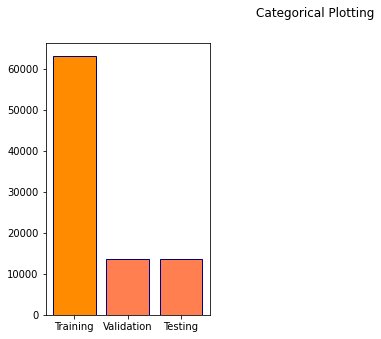

total time to complete all the above steps and get final data  53.42056655883789
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 300)      9544500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 80), (No 121920      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_____________

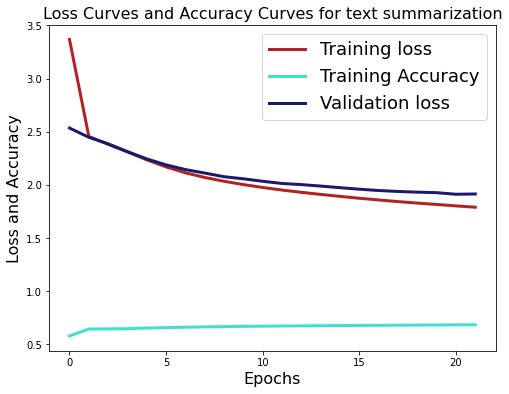

In [ ]:
lstmmodel()

In [ ]:
#summary using T5small pretrained model

In [ ]:
#step26
#function is used to return the loss
def step(inputs_ids, attention_mask, y, pad_token_id, model):
  y_ids = y[:, :-1].contiguous()
  lm_labels = y[:, 1:].clone()
  lm_labels[y[:, 1:] == pad_token_id] = -100
  output = model(inputs_ids, attention_mask=attention_mask, decoder_input_ids=y_ids, lm_labels=lm_labels)
  # loss
  return output[0] 

In [ ]:
#step25
#this function is used to train the pretrained t5small model
def t5train(train_loader,val_loader,pad_token_id,model,EPOCHS,log_interval):
  #initialize empty list for train_loss and val_loss
  train_loss = []
  val_loss = []
  #optimizer
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4/25)
  #iterate for number of epochs
  for epoch in range(EPOCHS):
    model.train() 
    #start time
    start_time = time.time()
    #for data in train_loader train the model
    for i, (inputs_ids, attention_mask, y) in enumerate(train_loader):
      inputs_ids = inputs_ids.to(device)
      attention_mask = attention_mask.to(device)
      y = y.to(device)
            
      optimizer.zero_grad()
      loss = step(inputs_ids, attention_mask, y, pad_token_id, model)
      train_loss.append(loss.item())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
            
      if (i + 1) % log_interval == 0:
        with torch.no_grad():
          x, x_mask, y = next(iter(val_loader))
          x = x.to(device)
          x_mask = x_mask.to(device)
          y = y.to(device)
                
          v_loss = step(x, x_mask, y, pad_token_id, model)
          v_loss = v_loss.item()
                
          elapsed = time.time() - start_time
          print('| epoch {:3d} | [{:5d}/{:5d}] | '
                'ms/batch {:5.2f} | '
                'loss {:5.2f} | val loss {:5.2f}'.format(
                  epoch, i, len(train_loader),
                  elapsed * 1000 / log_interval,
                  loss.item(), v_loss))
          start_time = time.time()
          val_loss.append(v_loss)

  return model

In [ ]:
#step26
#function to test the model it writes original and predicted summary in txt file
def testT5(model,tokenizer,test_loader):
  #intialize the empty lists
  predictions = []
  real_og=[]
  pred_op=[]
  c=0
  b=1000
  #for data in test loader
  for i, (input_ids, attention_mask, y) in enumerate(test_loader):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    y = y.to(device)
    #generate summaries 
    #store real and predicted summary in a list and write in txt file
    summaries = model.generate(input_ids=input_ids, attention_mask=attention_mask,max_length=10)
    pred = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summaries]
    real = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in y]
    for pred_sent, real_sent in zip(pred, real): 
      if c>b:
        print("Original: {}".format(real_sent))
        print("Predicted: {}".format(pred_sent))
        print("\n")
        b+=b
      real_og.append(real_sent)
      pred_op.append(pred_sent)
      predictions.append(str("pred sentence: " + pred_sent + "\t\t real sentence: " + real_sent+"\n"))
      c+=1
  file1 = open("/content/drive/MyDrive/TFIVE.txt","w")
  file1.writelines(predictions)
  file1.close()
  #calculate scores
  bleau=compute_bleu(real_og,pred_op, max_order=4,smooth=False)
  rougen=rouge_n(pred_op, real_og, n=2)
  ro=rouge(pred_op, real_og)

  print("bleu, precisions, bp, ratio, translation_length, reference_length",bleau)
  print("rouge2",rougen)
  print("rouge",ro)

In [ ]:
#step27
#fucntion to get the data and call all the functions in a squence
def tf5token():
  class MyDataset(torch.utils.data.Dataset):
    def __init__(self, articles, highlights):
      self.x = articles
      self.y = highlights
  
    def __getitem__(self,index):
      x = tokenizer.encode_plus(model.config.prefix + str(self.x[index]), max_length=80, return_tensors="pt", pad_to_max_length=True)
      y = tokenizer.encode(str(self.y[index]), max_length=10, return_tensors="pt", pad_to_max_length=True)
      return x['input_ids'].view(-1), x['attention_mask'].view(-1), y.view(-1)
        
    def __len__(self):
      return len(self.x)

  #get the data
  x_tr,y_tr,x_tt,y_tt,x_val,y_val=combining_all_steps_t5()
  BATCH_SIZE = 128
  SHUFFEL_SIZE = 1024
  EPOCHS = 25
  log_interval = 200
  #get the pretrained model t5-small
  tokenizer = T5Tokenizer.from_pretrained('t5-small')
  model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

  task_specific_params = model.config.task_specific_params
  if task_specific_params is not None:
    model.config.update(task_specific_params.get("summarization", {}))
  
  #create train,test and validation datasets
  train_ds = MyDataset(x_tr["reviewText"],y_tr["summary"]) 
  val_ds = MyDataset(x_val["reviewText"],y_val["summary"])
  test_ds = MyDataset(x_tt["reviewText"],y_tt["summary"])

  train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)
  val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE)
  test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE)

  x, x_mask, y = next(iter(val_loader))
  print(x.shape, x_mask.shape, y.shape)
  pad_token_id = tokenizer.pad_token_id

  #call the train function
  model=t5train(train_loader,val_loader,pad_token_id,model,EPOCHS,log_interval)
  #call the test function
  testT5(model,tokenizer,test_loader)

In [ ]:
tf5token()

The length of dataset is  117799
train 82459, val 17670, test 17670
torch.Size([128, 80]) torch.Size([128, 80]) torch.Size([128, 10])
| epoch   0 | [  199/  645] | ms/batch 376.53 | loss  4.30 | val loss  4.34
| epoch   0 | [  399/  645] | ms/batch 375.75 | loss  4.20 | val loss  4.14
| epoch   0 | [  599/  645] | ms/batch 376.28 | loss  4.10 | val loss  4.02
| epoch   1 | [  199/  645] | ms/batch 376.54 | loss  3.83 | val loss  3.96
| epoch   1 | [  399/  645] | ms/batch 375.83 | loss  3.80 | val loss  3.84
| epoch   1 | [  599/  645] | ms/batch 376.14 | loss  3.91 | val loss  3.76
| epoch   2 | [  199/  645] | ms/batch 376.54 | loss  3.72 | val loss  3.72
| epoch   2 | [  399/  645] | ms/batch 375.92 | loss  3.68 | val loss  3.65
| epoch   2 | [  599/  645] | ms/batch 376.34 | loss  3.74 | val loss  3.64
| epoch   3 | [  199/  645] | ms/batch 376.17 | loss  3.65 | val loss  3.59
| epoch   3 | [  399/  645] | ms/batch 376.04 | loss  3.55 | val loss  3.55
| epoch   3 | [  599/  645] | 